# Imports and Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
import random
import keras.backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

data_dir = "/kaggle/input/brats20-dataset-training-validation"
train_dir = os.path.join(data_dir, "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")


Text(0.5, 1.0, 'Mask')

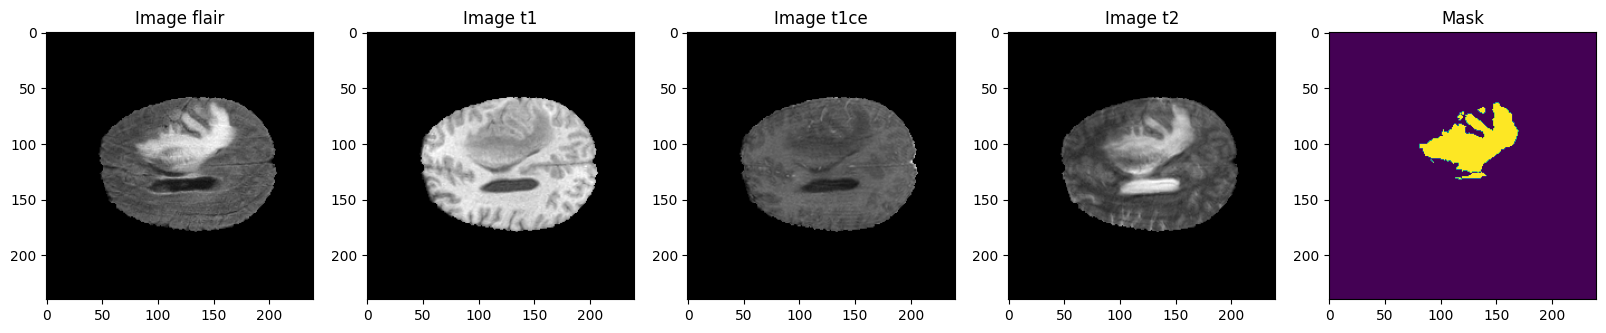

In [3]:
test_image_flair=nib.load(train_dir + '/BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(train_dir + '/BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(train_dir + '/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(train_dir + '/BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(train_dir + '/BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


In [4]:
def get_brats_data(root_dir):
    all_images = []
    
    subject_dirs = sorted([os.path.join(root_dir, d) for d in os.listdir(root_dir) 
                          if os.path.isdir(os.path.join(root_dir, d))])
    
    for subject_dir in subject_dirs:
        subject = os.path.basename(subject_dir)
        
        # Find the four modalities and the segmentation mask
        flair = os.path.join(subject_dir, f"{subject}_flair.nii")
        t1 = os.path.join(subject_dir, f"{subject}_t1.nii")
        t1ce = os.path.join(subject_dir, f"{subject}_t1ce.nii")
        t2 = os.path.join(subject_dir, f"{subject}_t2.nii")
        seg = os.path.join(subject_dir, f"{subject}_seg.nii")
        
        files = [flair, t1, t1ce, t2, seg]
        if all(os.path.exists(f) for f in files):
            all_images.append({
                "flair": flair,
                "t1": t1,
                "t1ce": t1ce,
                "t2": t2,
                "seg": seg,
                "subject": subject
            })
    
    return all_images

data_list = get_brats_data(train_dir)
print(f"Found {len(data_list)} subjects")


Found 368 subjects


**Train - Test Split:**

In [5]:
train_files, val_files = train_test_split(data_list, test_size=0.2, random_state=42)
print(f"Training: {len(train_files)}, Validation: {len(val_files)}")

Training: 294, Validation: 74


# Data Pre-Processing:

In [6]:
# Data preprocessing functions
def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize_scan(volume):
    """Normalize the volume"""
    min_val = np.min(volume)
    max_val = np.max(volume)
    if (max_val - min_val) != 0:
        volume = (volume - min_val) / (max_val - min_val)
    return volume

def resize_volume(img, desired_shape=(128, 128, 96)):
    """Resize across z-axis"""
    current_shape = img.shape
    # Padding or cropping
    if current_shape[0] < desired_shape[0]:
        diff = desired_shape[0] - current_shape[0]
        pad_before = diff // 2
        pad_after = diff - pad_before
        img = np.pad(img, ((pad_before, pad_after), (0, 0), (0, 0)), mode='constant')
    else:
        crop_start = (current_shape[0] - desired_shape[0]) // 2
        img = img[crop_start:crop_start + desired_shape[0], :, :]
    
    if current_shape[1] < desired_shape[1]:
        diff = desired_shape[1] - current_shape[1]
        pad_before = diff // 2
        pad_after = diff - pad_before
        img = np.pad(img, ((0, 0), (pad_before, pad_after), (0, 0)), mode='constant')
    else:
        crop_start = (current_shape[1] - desired_shape[1]) // 2
        img = img[:, crop_start:crop_start + desired_shape[1], :]
    
    if current_shape[2] < desired_shape[2]:
        diff = desired_shape[2] - current_shape[2]
        pad_before = diff // 2
        pad_after = diff - pad_before
        img = np.pad(img, ((0, 0), (0, 0), (pad_before, pad_after)), mode='constant')
    else:
        crop_start = (current_shape[2] - desired_shape[2]) // 2
        img = img[:, :, crop_start:crop_start + desired_shape[2]]
    
    return img

def process_scan(path):
    """Read and resize volume"""
    volume = read_nifti_file(path)
    volume = normalize_scan(volume)
    volume = resize_volume(volume)
    return volume
def process_scany(path):
    """Read and resize volume"""
    volume = read_nifti_file(path)
    volume = resize_volume(volume)
    return volume

def center_crop_3d(img, crop_size=(128, 128, 96)):
    """Center crop 3D image"""
    h, w, d = img.shape
    ch, cw, cd = crop_size
    
    x = (h - ch) // 2
    y = (w - cw) // 2
    z = (d - cd) // 2
    
    img_crop = img[x:x+ch, y:y+cw, z:z+cd]
    
    return img_crop

# Data Generator

In [7]:
class BraTSDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_list, batch_size=1, dim=(128, 128, 96), n_channels=4, 
                 n_classes=4, shuffle=True):
        self.data_list = data_list
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.data_list) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Find list of IDs
        data_temp = [self.data_list[i] for i in indexes]
        X, y = self.__data_generation(data_temp)
        
        return X, y
    
    def __data_generation(self, data_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # One-hot encoded output - shape will be (batch_size, height, width, depth, n_classes)
        y = np.empty((self.batch_size, *self.dim, self.n_classes))
        
        for i, data in enumerate(data_temp):
            t1 = process_scan(data['t1'])
            t1ce = process_scan(data['t1ce'])
            t2 = process_scan(data['t2'])
            flair = process_scan(data['flair'])
            
            seg = process_scany(data['seg'])
            
            t1 = center_crop_3d(t1, self.dim)
            t1ce = center_crop_3d(t1ce, self.dim)
            t2 = center_crop_3d(t2, self.dim)
            flair = center_crop_3d(flair, self.dim)
            seg = center_crop_3d(seg, self.dim)
            
            img = np.stack([t1, t1ce, t2, flair], axis=-1)
            
            # Convert BraTS labels (0, 1, 2, 4) to (0, 1, 2, 3)
            seg[seg == 4] = 3
            # Convert segmentation to one-hot encoding
            seg_one_hot = tf.one_hot(seg,4)
            X[i,] = img
            y[i,] = seg_one_hot
            
        return X, y

train_generator = BraTSDataGenerator(
    train_files, 
    batch_size=2, 
    dim=(128, 128, 96),  
    n_channels=4, 
    n_classes=4, 
    shuffle=True
)

val_generator = BraTSDataGenerator(
    val_files, 
    batch_size=1, 
    dim=(128, 128, 96),
    n_channels=4, 
    n_classes=4, 
    shuffle=False
)

In [7]:
X, y = train_generator[0]
print("X shape:", X.shape)  
print("y shape:", y.shape)  


X shape: (2, 128, 128, 96, 4)
y shape: (2, 128, 128, 96, 4)


In [40]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

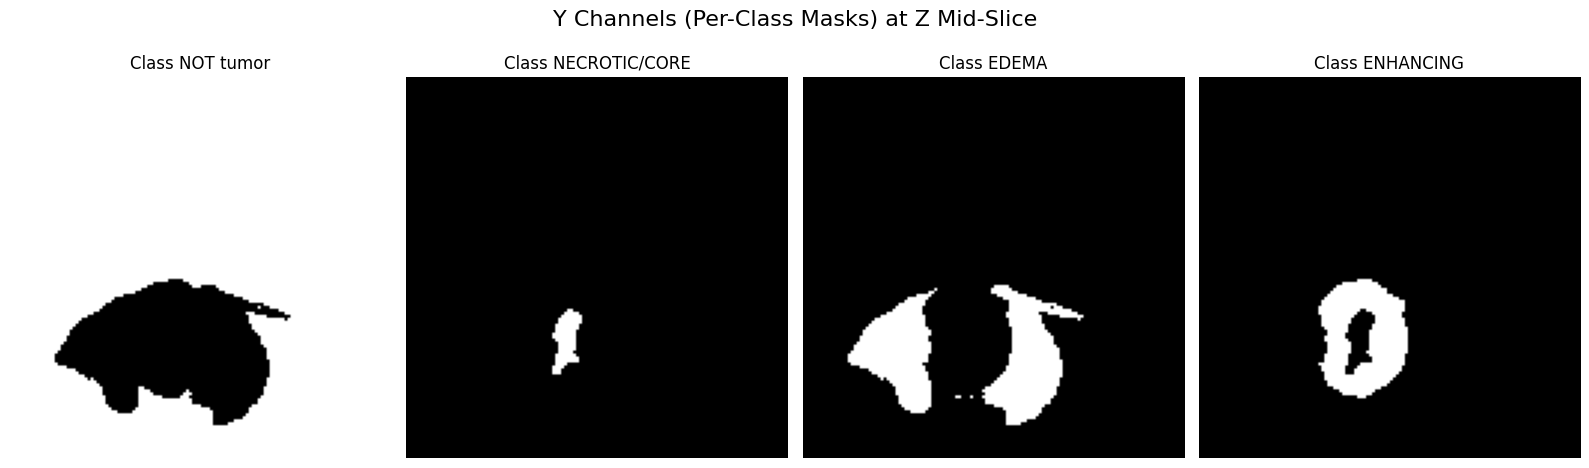

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch
X_batch, Y_batch = train_generator[50]

Y_sample = Y_batch[1]  

num_classes = Y_sample.shape[-1]

z_index = 60

plt.figure(figsize=(4 * num_classes, 5))
for class_idx in range(num_classes):
    class_channel = Y_sample[..., class_idx]  # shape: (H, W, D)
    class_slice = class_channel[:, :, z_index]  # shape: (H, W)

    plt.subplot(1, num_classes, class_idx + 1)
    plt.imshow(class_slice, cmap='gray')
    plt.title(f'Class {SEGMENT_CLASSES[class_idx]}')
    plt.axis('off')

plt.suptitle("Y Channels (Per-Class Masks) at Z Mid-Slice", fontsize=16)
plt.tight_layout()
plt.show()




# Model Implementation and Training

In [10]:
# Define residual block for the SegResNet architecture
def residual_block(inputs, filters, kernel_size=3, strides=1):
    x = layers.Conv3D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    
    x = layers.Conv3D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    if strides > 1 or inputs.shape[-1] != filters:
        skip = layers.Conv3D(filters, 1, strides=strides, padding='same')(inputs)
        skip = layers.BatchNormalization()(skip)
    else:
        skip = inputs
    
    x = layers.Add()([x, skip])
    x = layers.LeakyReLU(alpha=0.01)(x)
    return x

# Build the SegResNet model
def build_segresnet(input_shape=(128, 128, 128, 4), num_classes=4):
    inputs = layers.Input(input_shape)
    
    # Initial convolution
    x = layers.Conv3D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    
    # Encoder path
    skip_connections = []
    
    # Encoder block 1
    x = residual_block(x, 32)
    skip_connections.append(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    
    # Encoder block 2
    x = residual_block(x, 64)
    skip_connections.append(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    
    # Encoder block 3
    x = residual_block(x, 128)
    skip_connections.append(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    
    # Bridge
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    
    # Decoder path
    skip_connections = skip_connections[::-1]  # Reverse the list for decoder
    
    # Decoder block 1
    x = layers.UpSampling3D(size=2)(x)
    x = layers.Concatenate()([x, skip_connections[0]])
    x = residual_block(x, 128)
    
    # Decoder block 2
    x = layers.UpSampling3D(size=2)(x)
    x = layers.Concatenate()([x, skip_connections[1]])
    x = residual_block(x, 64)
    
    # Decoder block 3
    x = layers.UpSampling3D(size=2)(x)
    x = layers.Concatenate()([x, skip_connections[2]])
    x = residual_block(x, 32)
    
    # Output layer
    outputs = layers.Conv3D(num_classes, 1, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

***Custom Loss Fucntion***

In [11]:
def dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1.0):
    return 1 - dice_coefficient(y_true, y_pred, smooth)

# Custom Loss Function
def combined_loss(y_true, y_pred):
    # Calculate dice loss
    dice = dice_loss(y_true, y_pred)
    
    # Calculate categorical crossentropy
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return dice + ce

# Define custom metrics for multi-class segmentation
class DiceCoefficient(tf.keras.metrics.Metric):
    def __init__(self, class_id, name="dice_coefficient", **kwargs):
        super(DiceCoefficient, self).__init__(name=name, **kwargs)
        self.class_id = class_id
        self.dice_sum = self.add_weight(name="dice_sum", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_mask = tf.cast(y_true[..., self.class_id], tf.float32)
        # Convert predictions to class labels
        y_pred_class = tf.argmax(y_pred, axis=-1)
        # Create binary mask for this class from predictions
        y_pred_mask = tf.cast(y_pred_class == self.class_id, tf.float32)
        # Calculate dice
        intersection = tf.reduce_sum(y_true_mask * y_pred_mask)
        union = tf.reduce_sum(y_true_mask) + tf.reduce_sum(y_pred_mask)
        dice = (2.0 * intersection + 1.0) / (union + 1.0)
        self.dice_sum.assign_add(dice)
        self.count.assign_add(1)

    def result(self):
        return self.dice_sum / self.count

    def reset_state(self):
        self.dice_sum.assign(0)
        self.count.assign(0)


In [11]:
model = build_segresnet(input_shape=(128,128, 96, 4), num_classes=4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['accuracy',
        DiceCoefficient(class_id=1, name="dice_class1"),  # Necrotic tumor core
        DiceCoefficient(class_id=2, name="dice_class2"),  # Peritumoral edema
        DiceCoefficient(class_id=3, name="dice_class3"), 
        tf.keras.metrics.MeanIoU(num_classes=4)# Enhancing tumor
    ]
)
#model.summary()

In [ ]:
plot_model(model, 
           show_shapes = False,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'LR', 
           expand_nested = False, 
           dpi = 70)

***Run the below cell only if u want to train the model else skip it.***

In [ ]:
checkpoint_filepath = './best_model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
csv_logger = CSVLogger('training.log', separator=',', append=False)
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr, csv_logger]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 691s 4s/step - accuracy: 0.8636 - dice_class1: 0.1913 - dice_class2: 0.4294 - dice_class3: 0.1713 - loss: 0.7861 - mean_io_u: 0.2524 - val_accuracy: 0.9400 - val_dice_class1: 0.0015 - val_dice_class2: 0.0136 - val_dice_class3: 0.0677 - val_loss: 0.5483 - val_mean_io_u: 0.2500 - learning_rate: 1.0000e-04
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 578s 4s/step - accuracy: 0.9660 - dice_class1: 0.2927 - dice_class2: 0.6119 - dice_class3: 0.5084 - loss: 0.2675 - mean_io_u: 0.2524 - val_accuracy: 0.9426 - val_dice_class1: 0.0130 - val_dice_class2: 0.0474 - val_dice_class3: 0.1331 - val_loss: 0.3694 - val_mean_io_u: 0.2500 - learning_rate: 1.0000e-04
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.9678 - dice_class1: 0.3500 - dice_class2: 0.6110 - dice_class3: 0.5907 - loss: 0.2152 - mean_io_u: 0.2524 - val_accuracy: 0.9381 - val_dice_class1: 0.0282 - val_dice_class2: 0.4080 - val_dice_class3: 0.3112 - val_loss: 0.3275 - val_mean_io_u: 0.2500 - le

***Run the below cell to import the trained model***

In [12]:
model = tf.keras.models.load_model(
    "/kaggle/input/finalmodel_brats/keras/default/1/best_model (2).keras",
    compile=False
)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['accuracy',
        DiceCoefficient(class_id=1, name="dice_class1"),  # Necrotic tumor core
        DiceCoefficient(class_id=2, name="dice_class2"),  # Peritumoral edema
        DiceCoefficient(class_id=3, name="dice_class3"), 
        tf.keras.metrics.MeanIoU(num_classes=4)# Enhancing tumor
    ]
)
#model.summary()

# Training Results

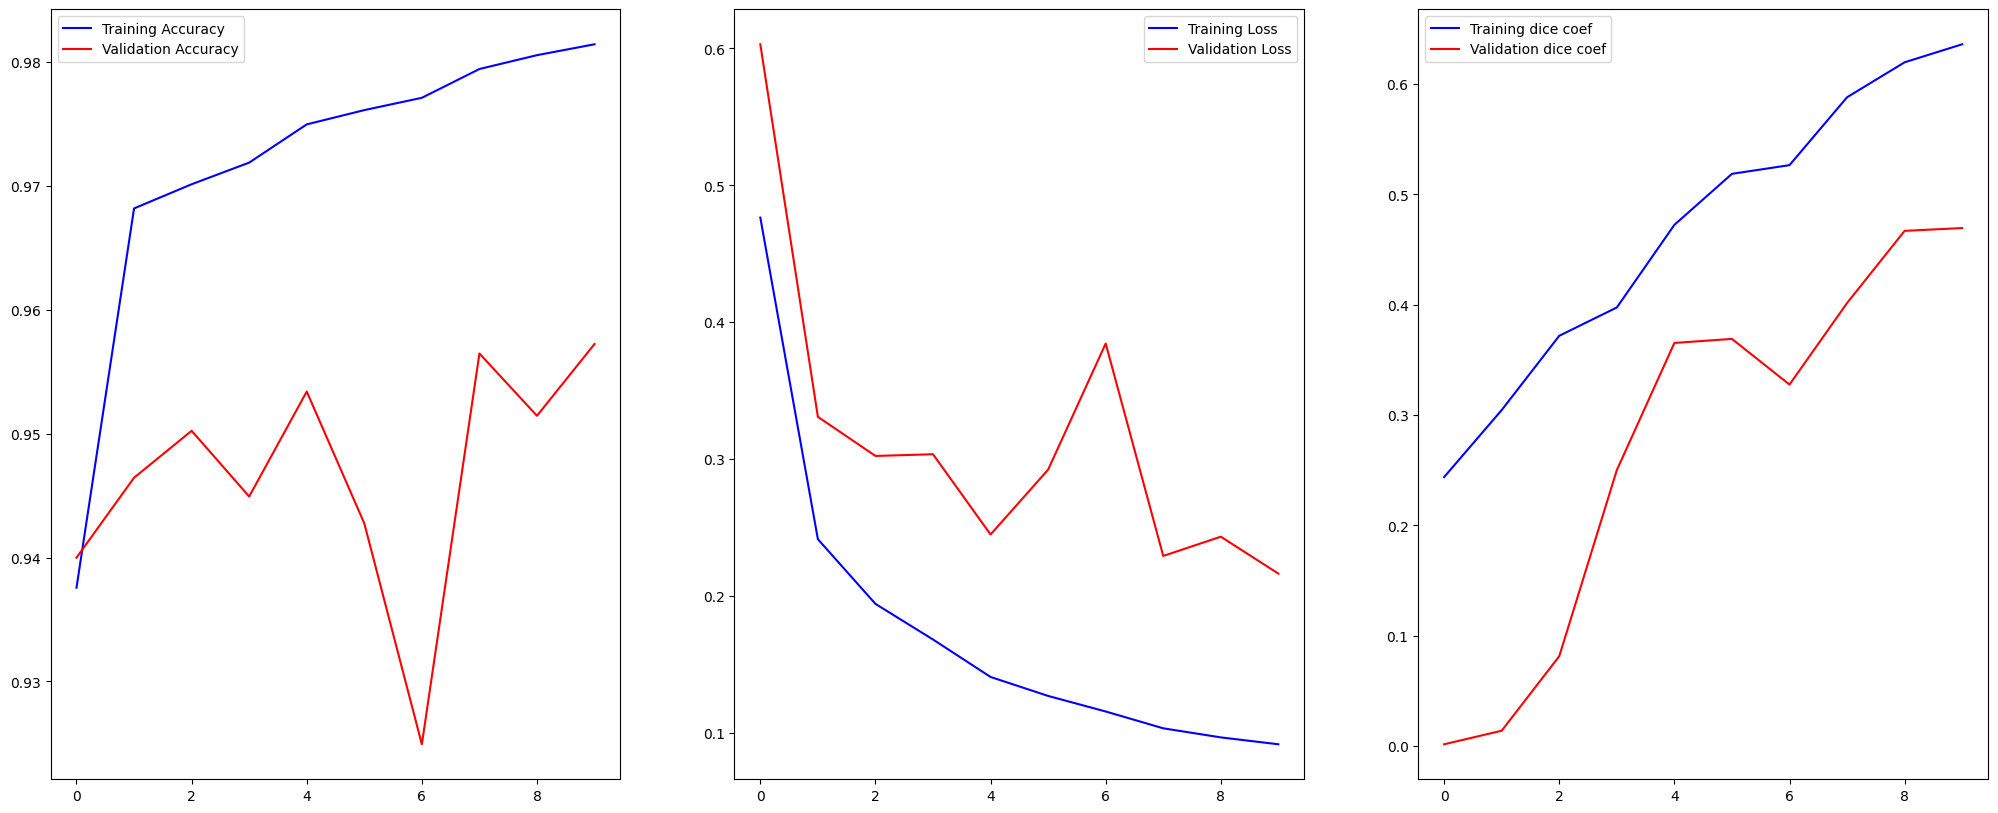

In [13]:
history = pd.read_csv('/kaggle/input/finalmodel_brats/keras/default/1/training.log', sep=',', engine='python')

hist=history
acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice1=hist['dice_class1']
val_dice=hist['val_dice_class1']

f,ax=plt.subplots(1,3,figsize=(25,10))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice1,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()


plt.show()

# Validation Results:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

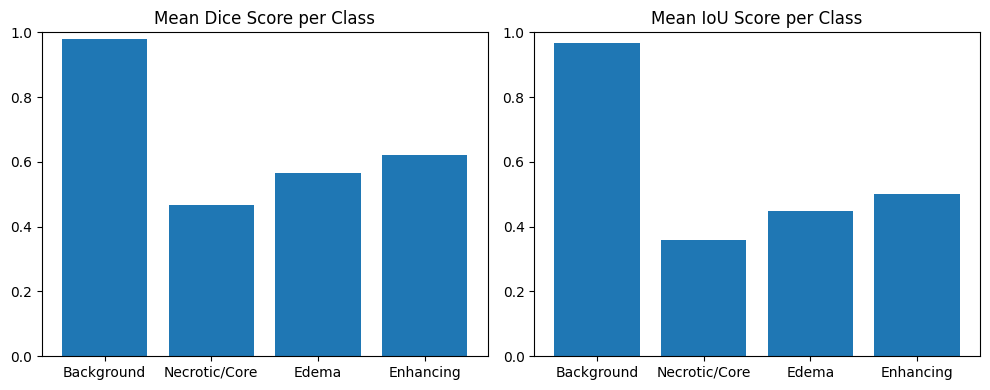

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import tensorflow as tf

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true, axis=(0, 1, 2)) + np.sum(y_pred, axis=(0, 1, 2))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true + y_pred, axis=(0, 1, 2)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

dice_scores = []
iou_scores = []

for i in range(len(val_generator)):
    x_val, y_val = val_generator[i]
    y_pred = model.predict(x_val)

    y_val_argmax = np.argmax(y_val, axis=-1)
    y_pred_argmax = np.argmax(y_pred, axis=-1)

    for b in range(x_val.shape[0]):
        y_true_b = tf.one_hot(y_val_argmax[b], depth=4).numpy()
        y_pred_b = tf.one_hot(y_pred_argmax[b], depth=4).numpy()

        dice_scores.append(dice_score(y_true_b, y_pred_b))
        iou_scores.append(iou_score(y_true_b, y_pred_b))

dice_scores = np.array(dice_scores)
iou_scores = np.array(iou_scores)

print("Mean Dice Score (per class):", dice_scores.mean(axis=0))
print("Mean IoU Score (per class):", iou_scores.mean(axis=0))

# ---- Plotting Accuracy Metrics ---- #
labels = ["Background", "Necrotic/Core", "Edema", "Enhancing"]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(labels, dice_scores.mean(axis=0))
plt.title("Mean Dice Score per Class")
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(labels, iou_scores.mean(axis=0))
plt.title("Mean IoU Score per Class")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


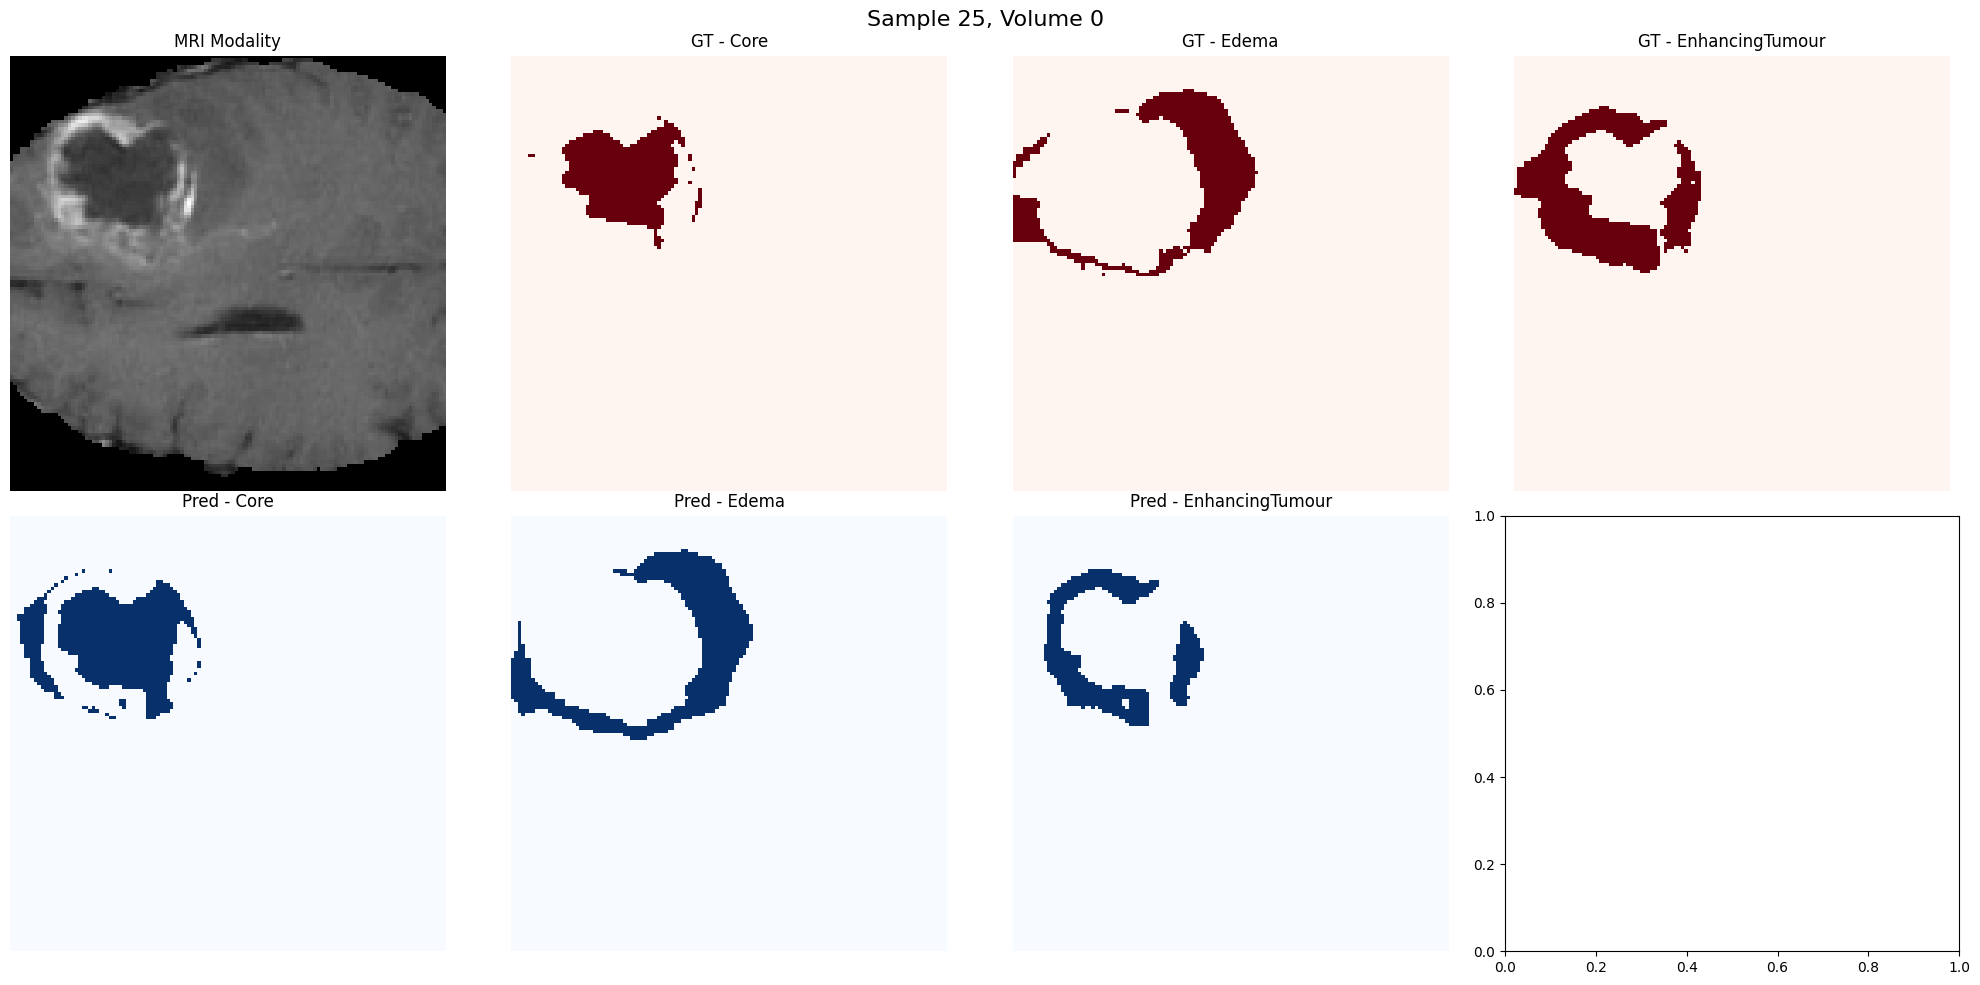

In [14]:

# ---- Slice Visualization Function ---- #
def visualize_slices(idx=0, modality_index=0):
    x, y = val_generator[idx]
    y_pred = model.predict(x)

    for i in range(x.shape[0]):
        mid_slice = x.shape[1] // 2
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))
        axs = axs.ravel()

        axs[0].imshow(x[i, :, :, mid_slice, modality_index], cmap='gray')
        axs[0].set_title("MRI Modality")
        axs[0].axis('off')

        class_names = ["Core", "Edema", "EnhancingTumour"]
        for c in range(1, 4):
            axs[c].imshow(y[i, :, :, mid_slice, c], cmap='Reds')
            axs[c].set_title(f"GT - {class_names[c-1]}")
            axs[c].axis('off')

        for c in range(1, 4):
            axs[c+3].imshow(np.argmax(y_pred[i, :, :, mid_slice], axis=-1) == c, cmap='Blues')
            axs[c+3].set_title(f"Pred - {class_names[c-1]}")
            axs[c+3].axis('off')

        plt.suptitle(f"Sample {idx}, Volume {i}", fontsize=16)
        plt.tight_layout()
        plt.show()

# Example: Visualize first batch and first modality
visualize_slices(idx=25, modality_index=1)


***Visualizing a few example predictions:***

Generating visualizations...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


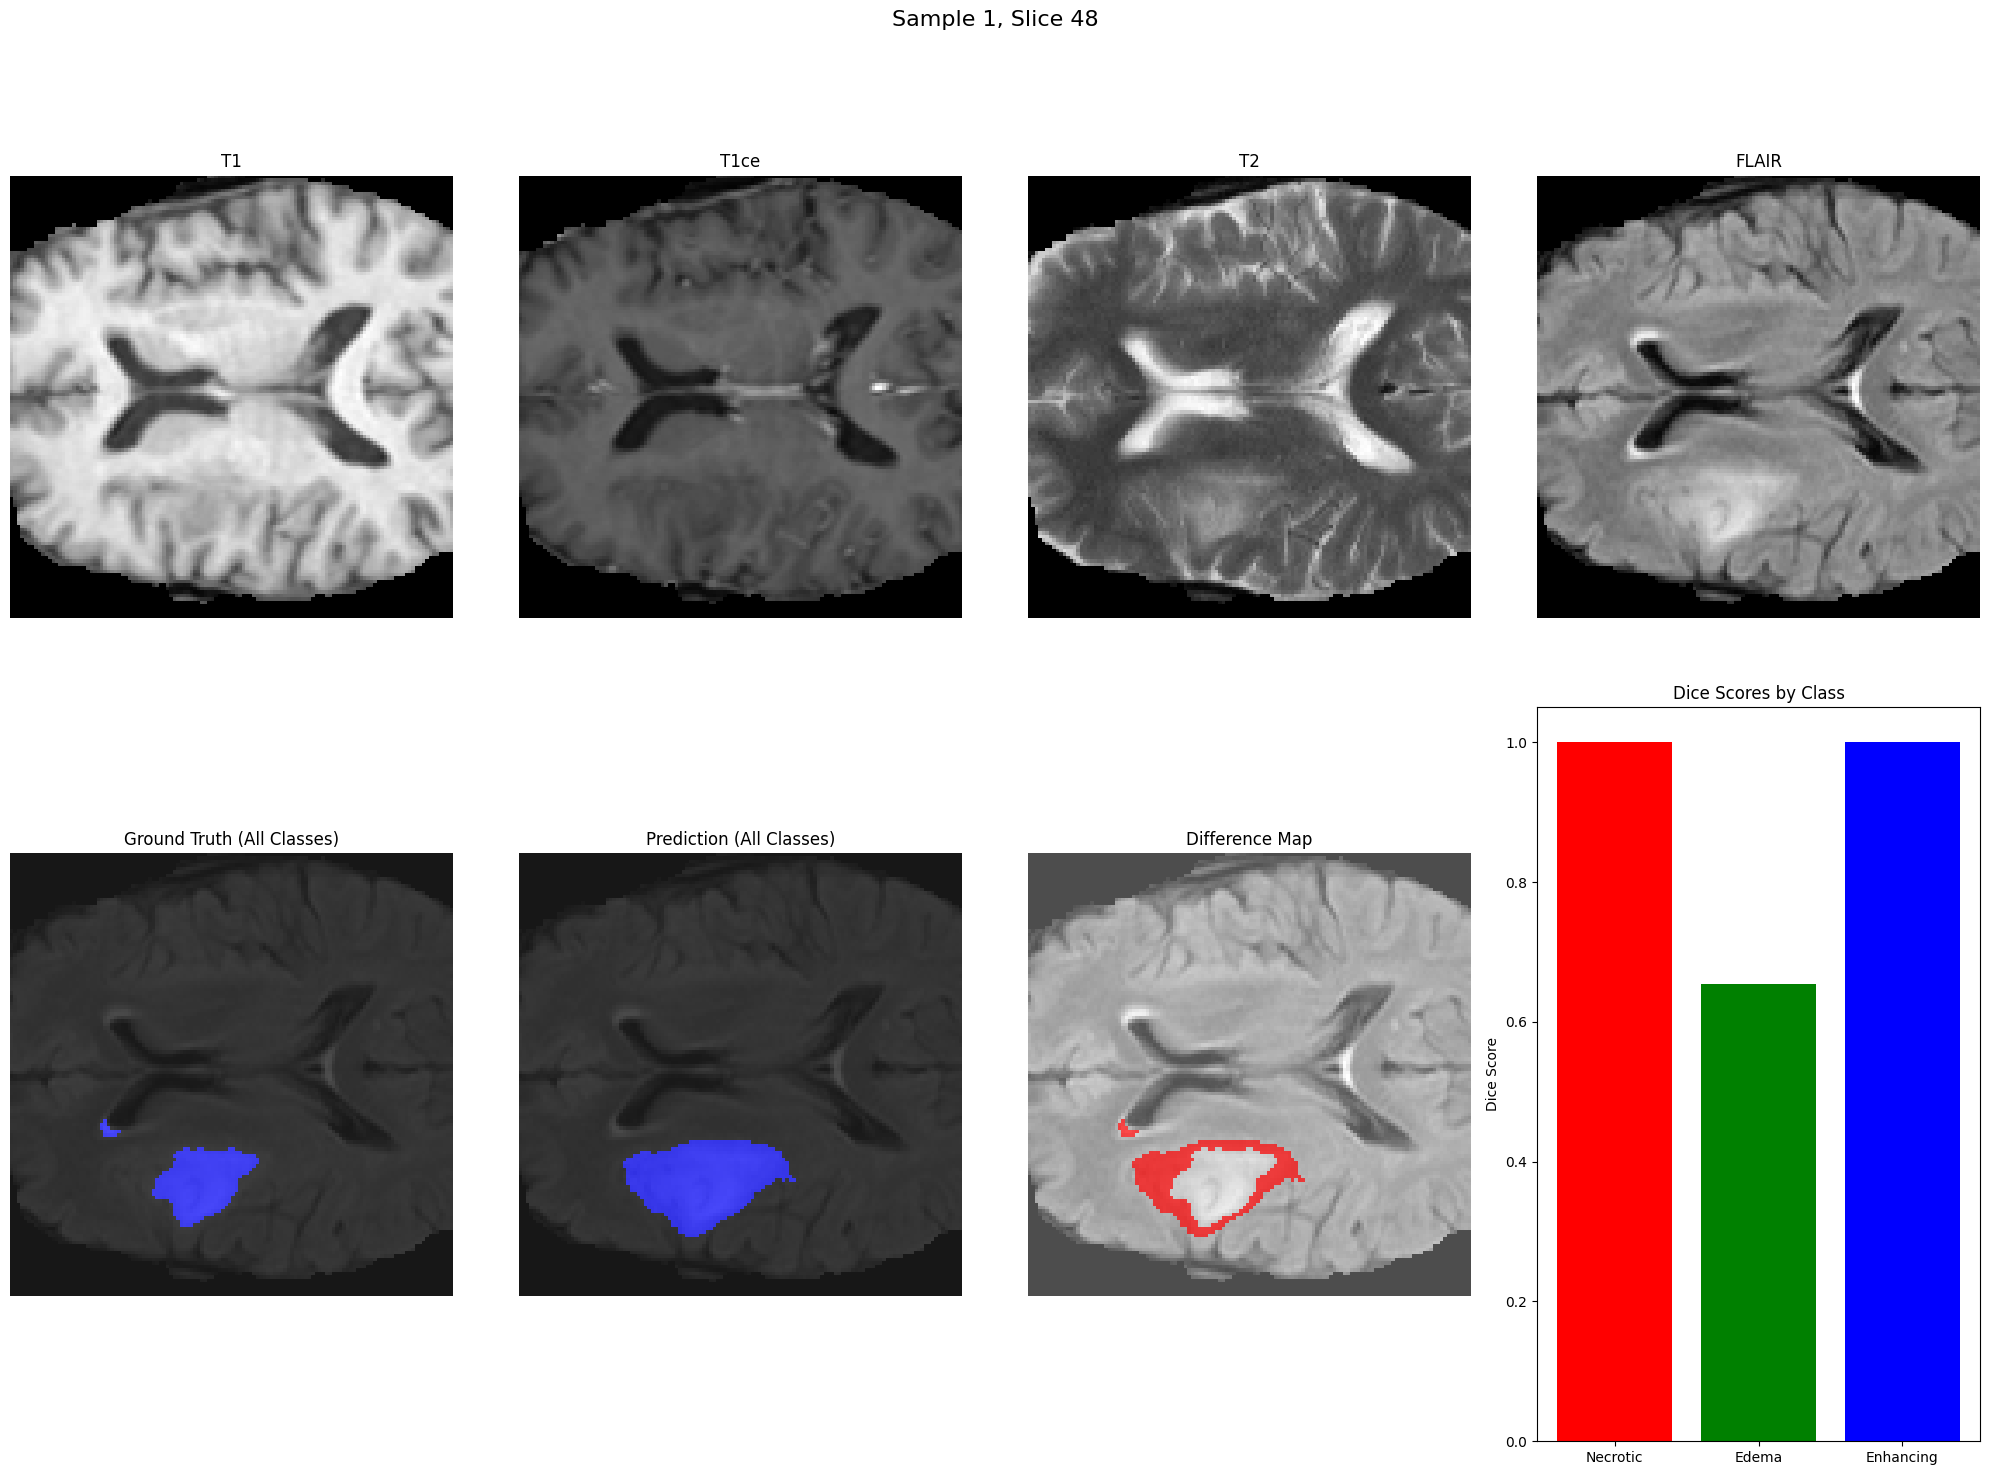

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


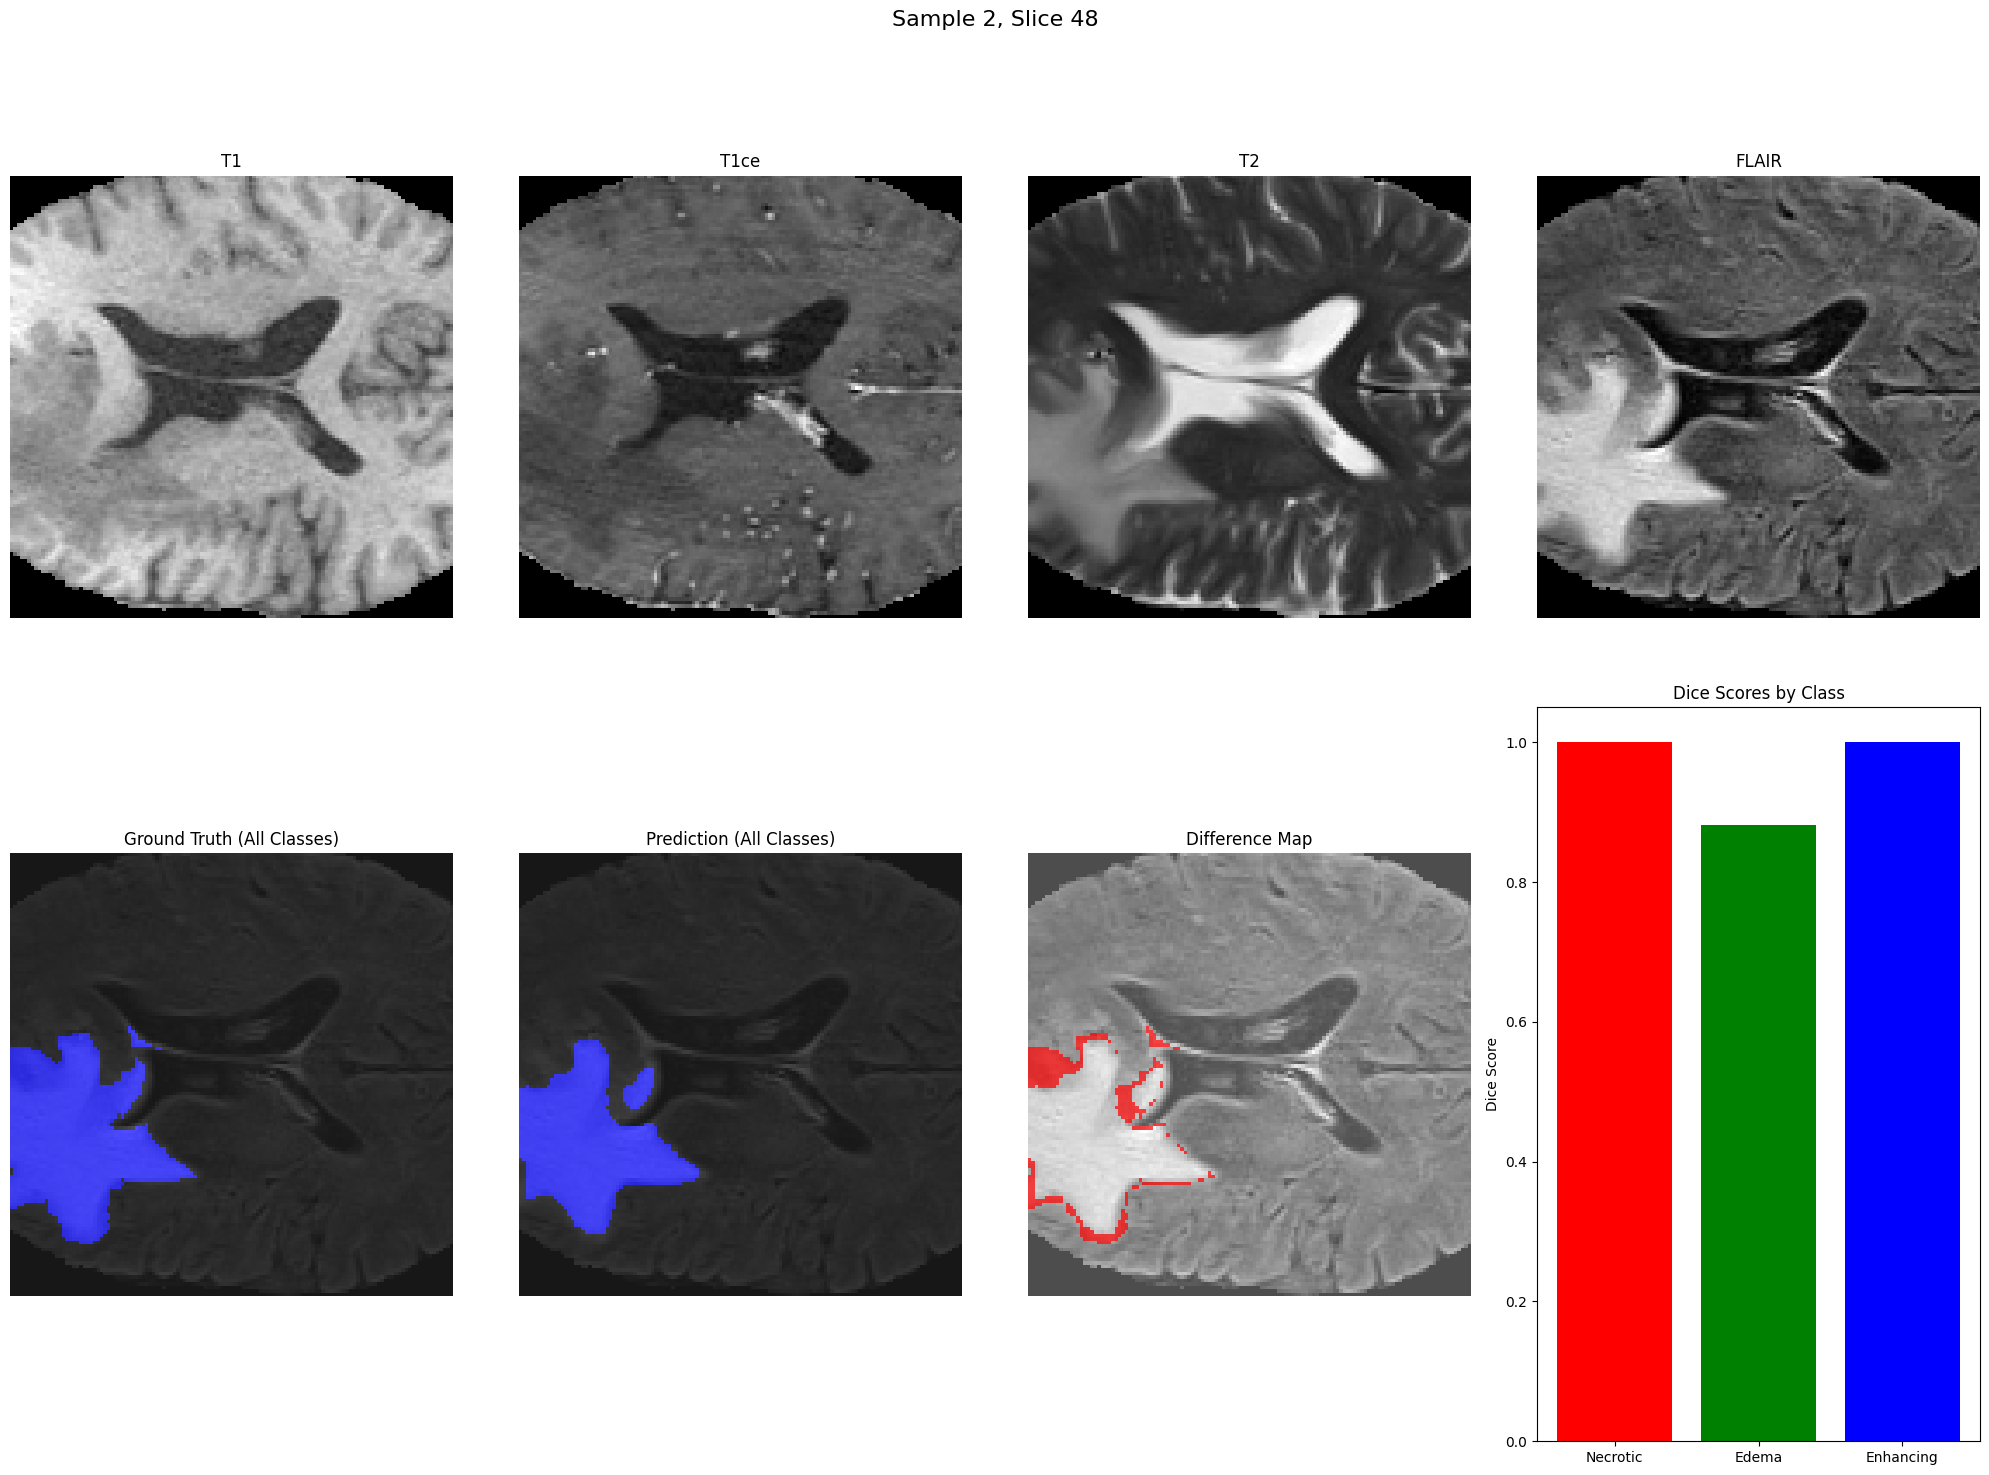

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


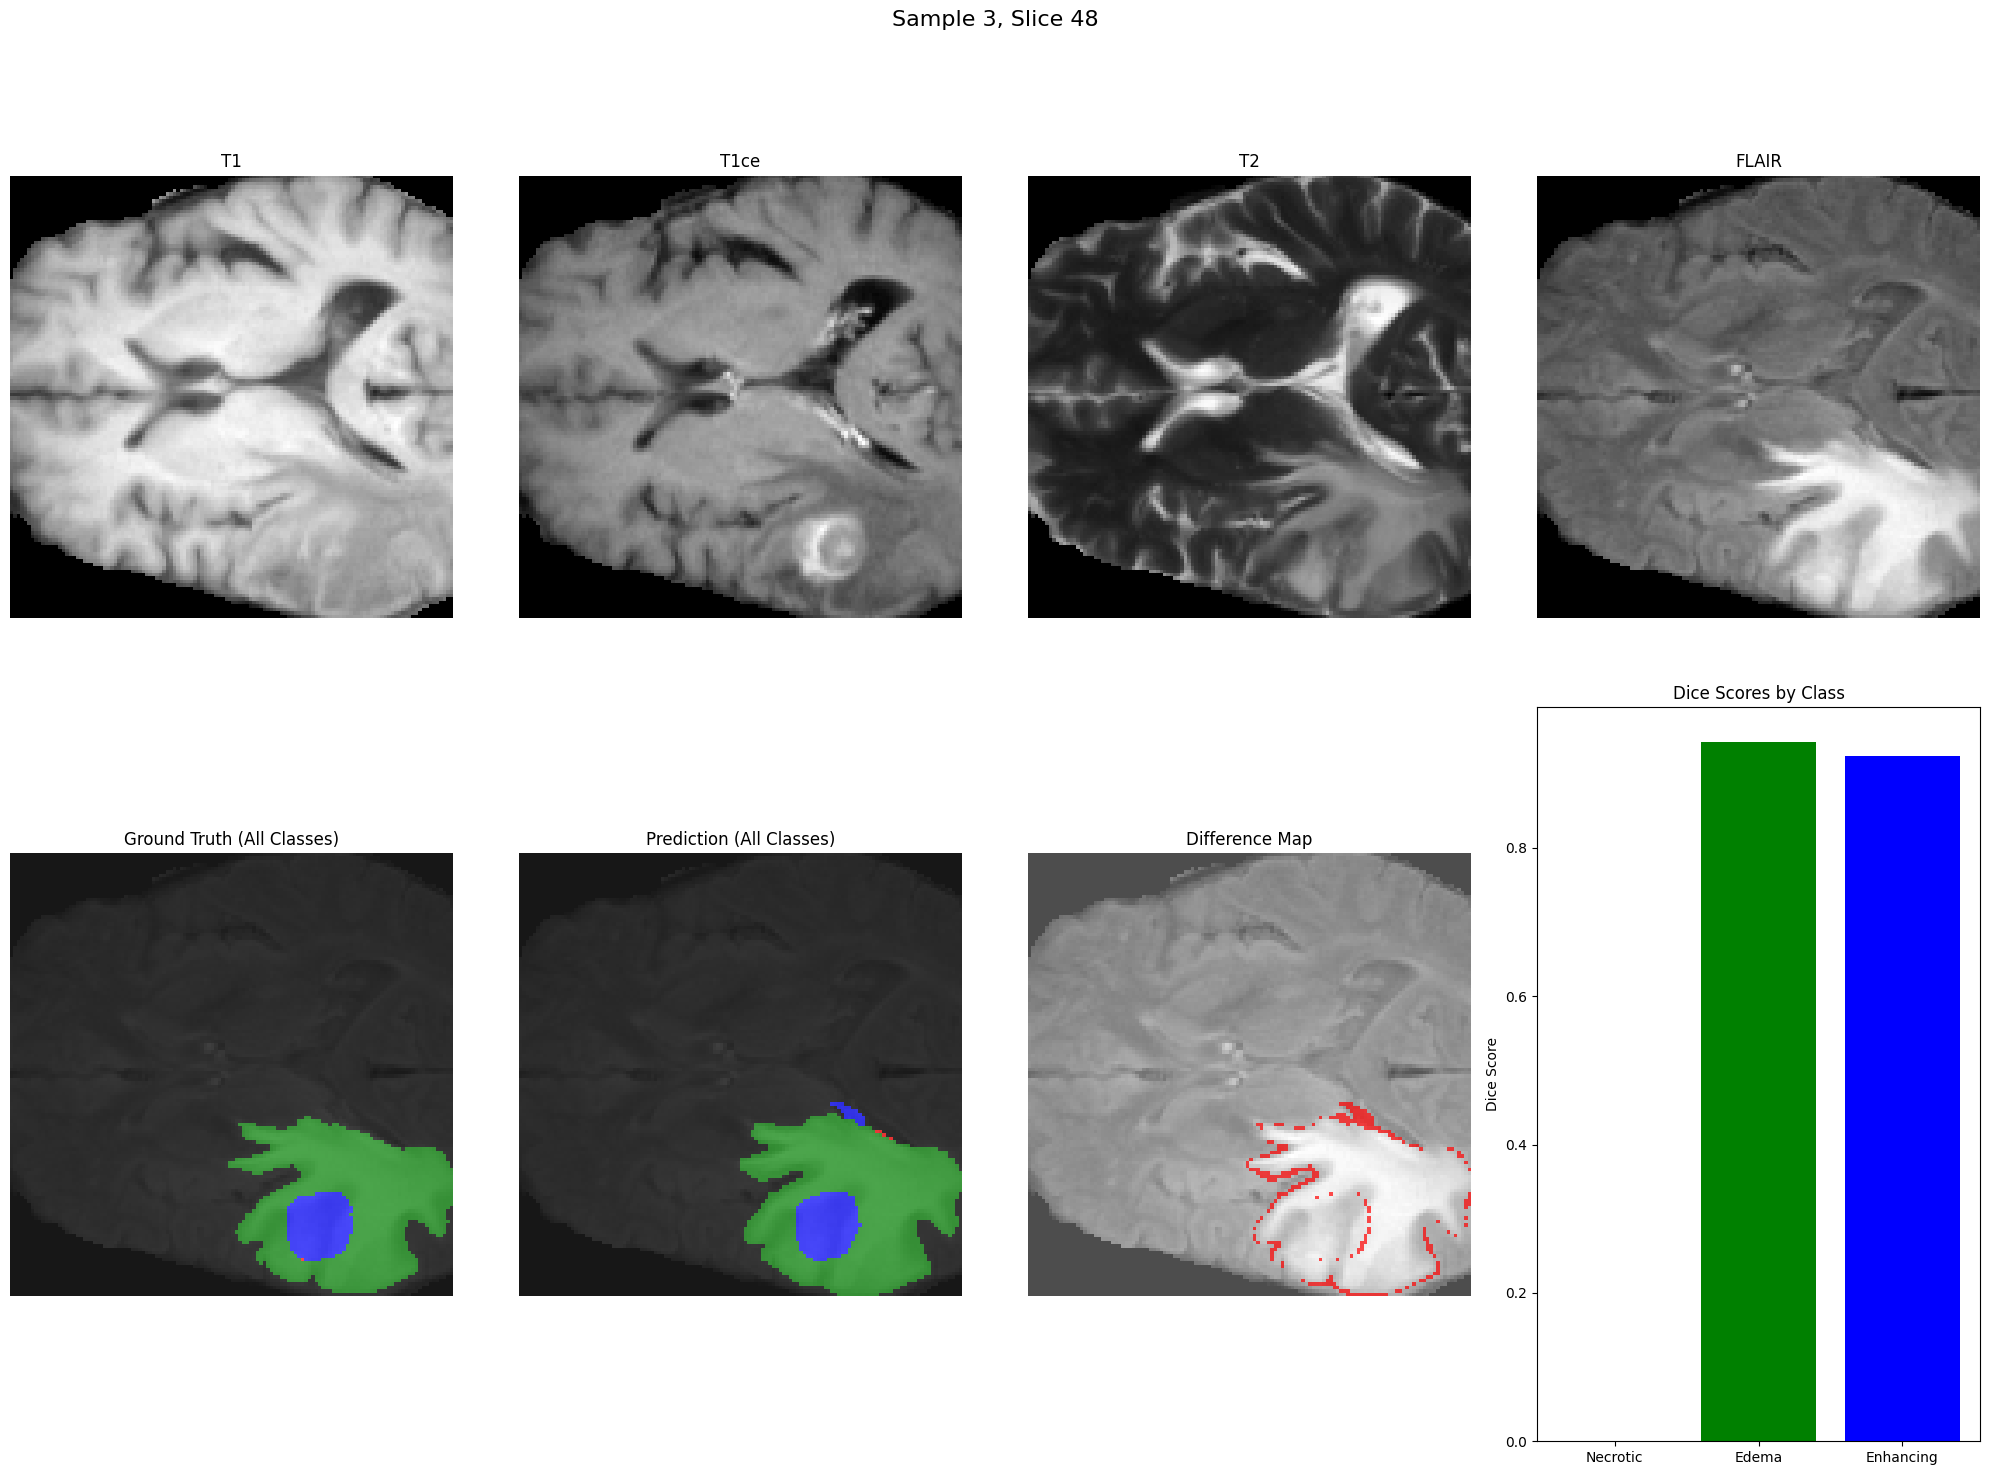

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


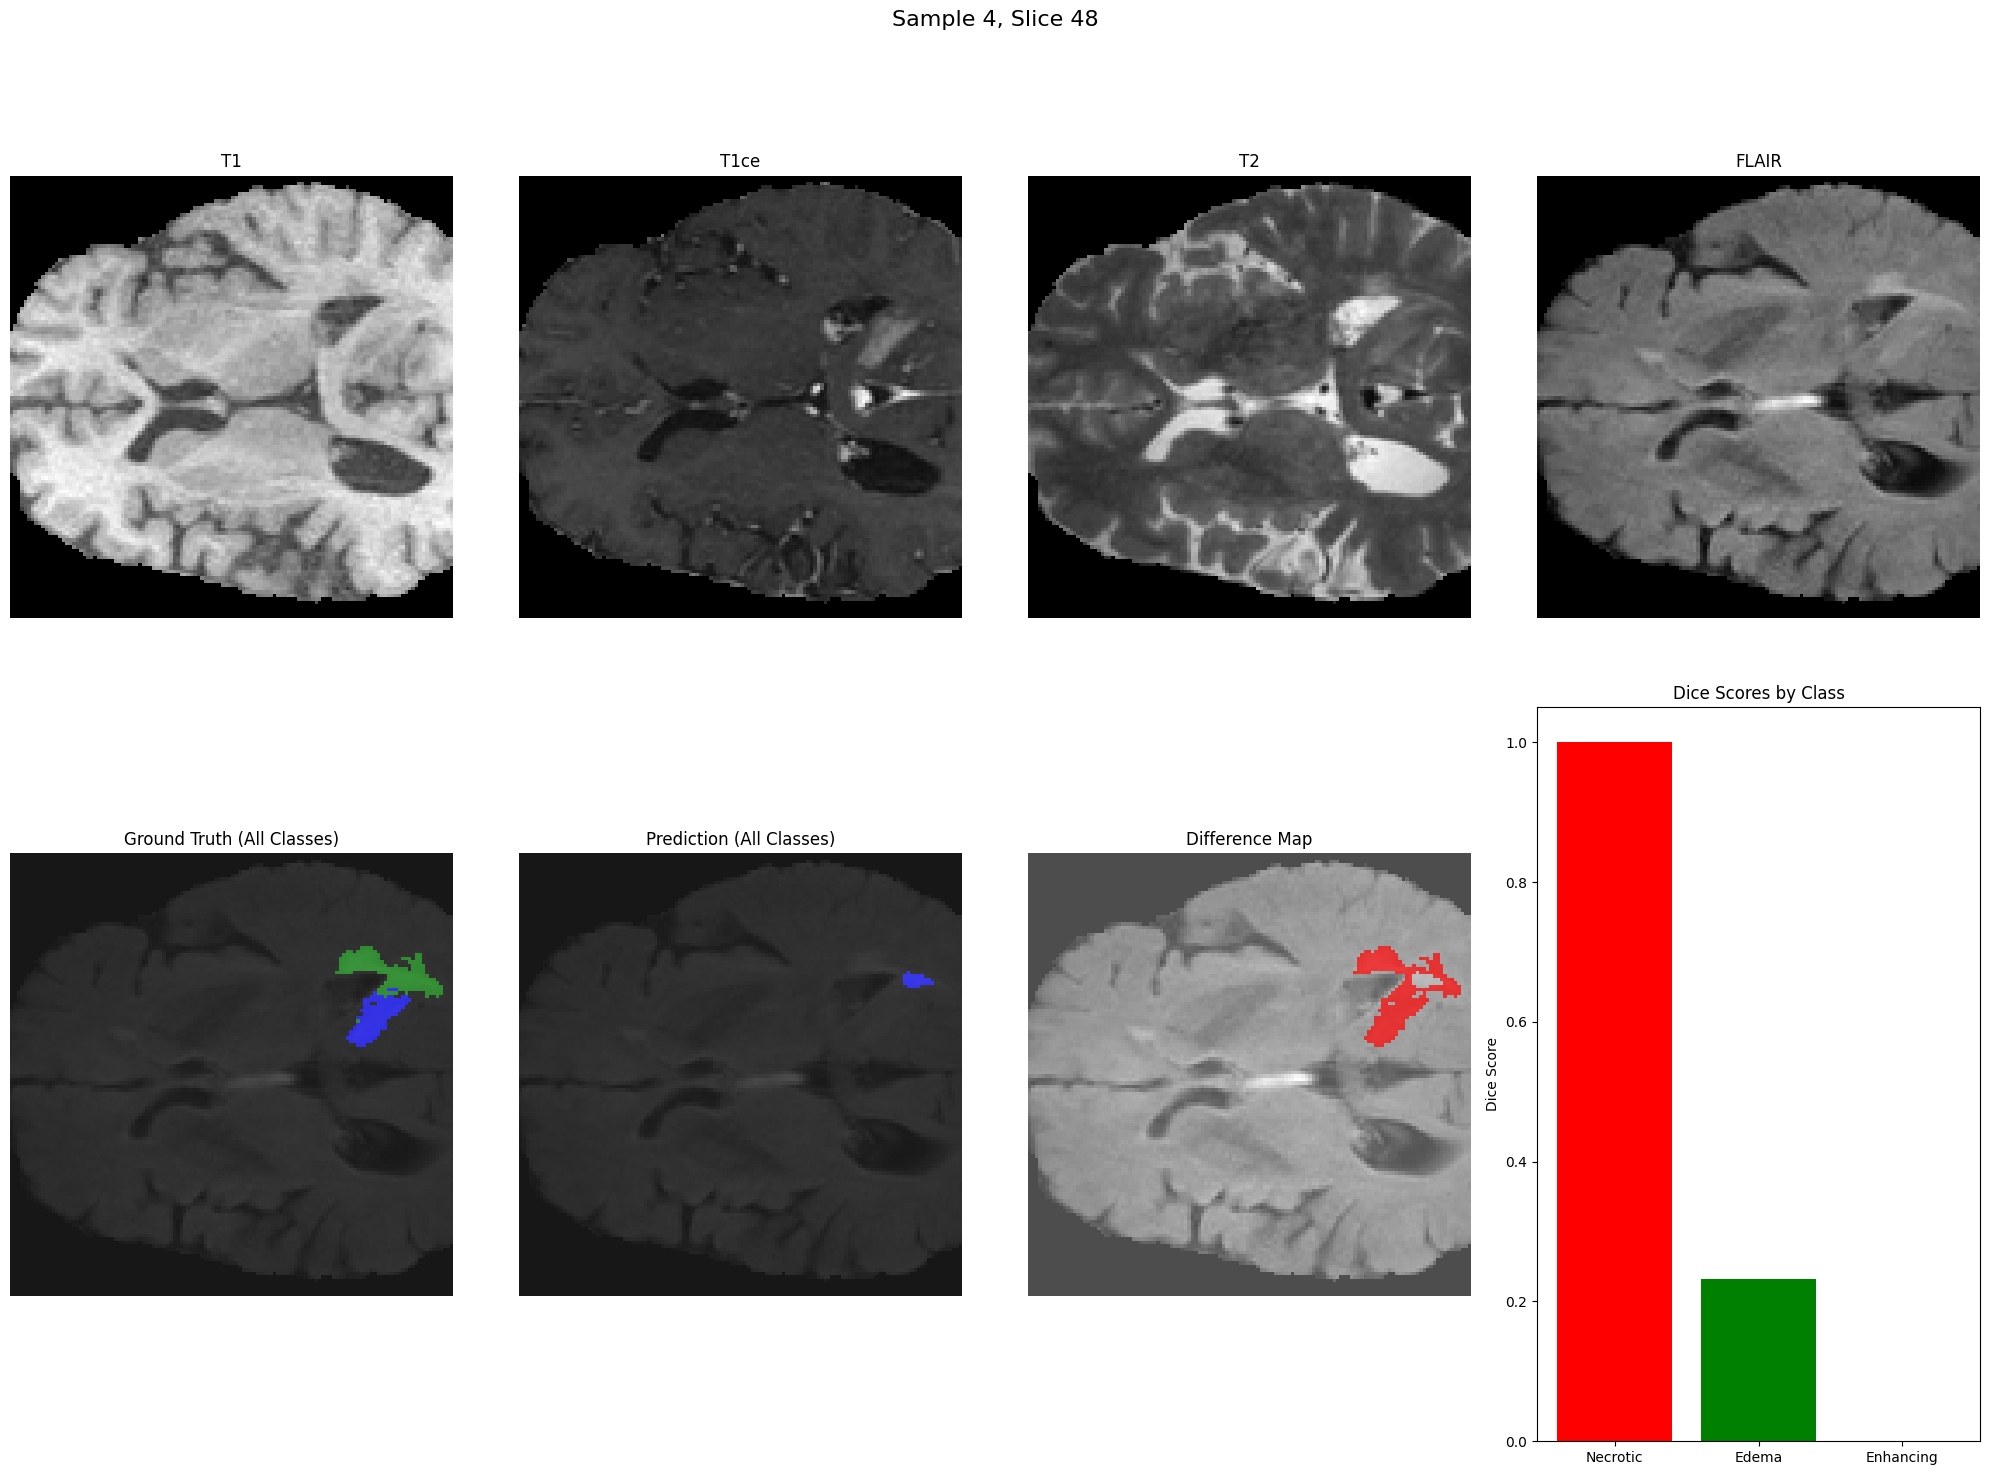

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


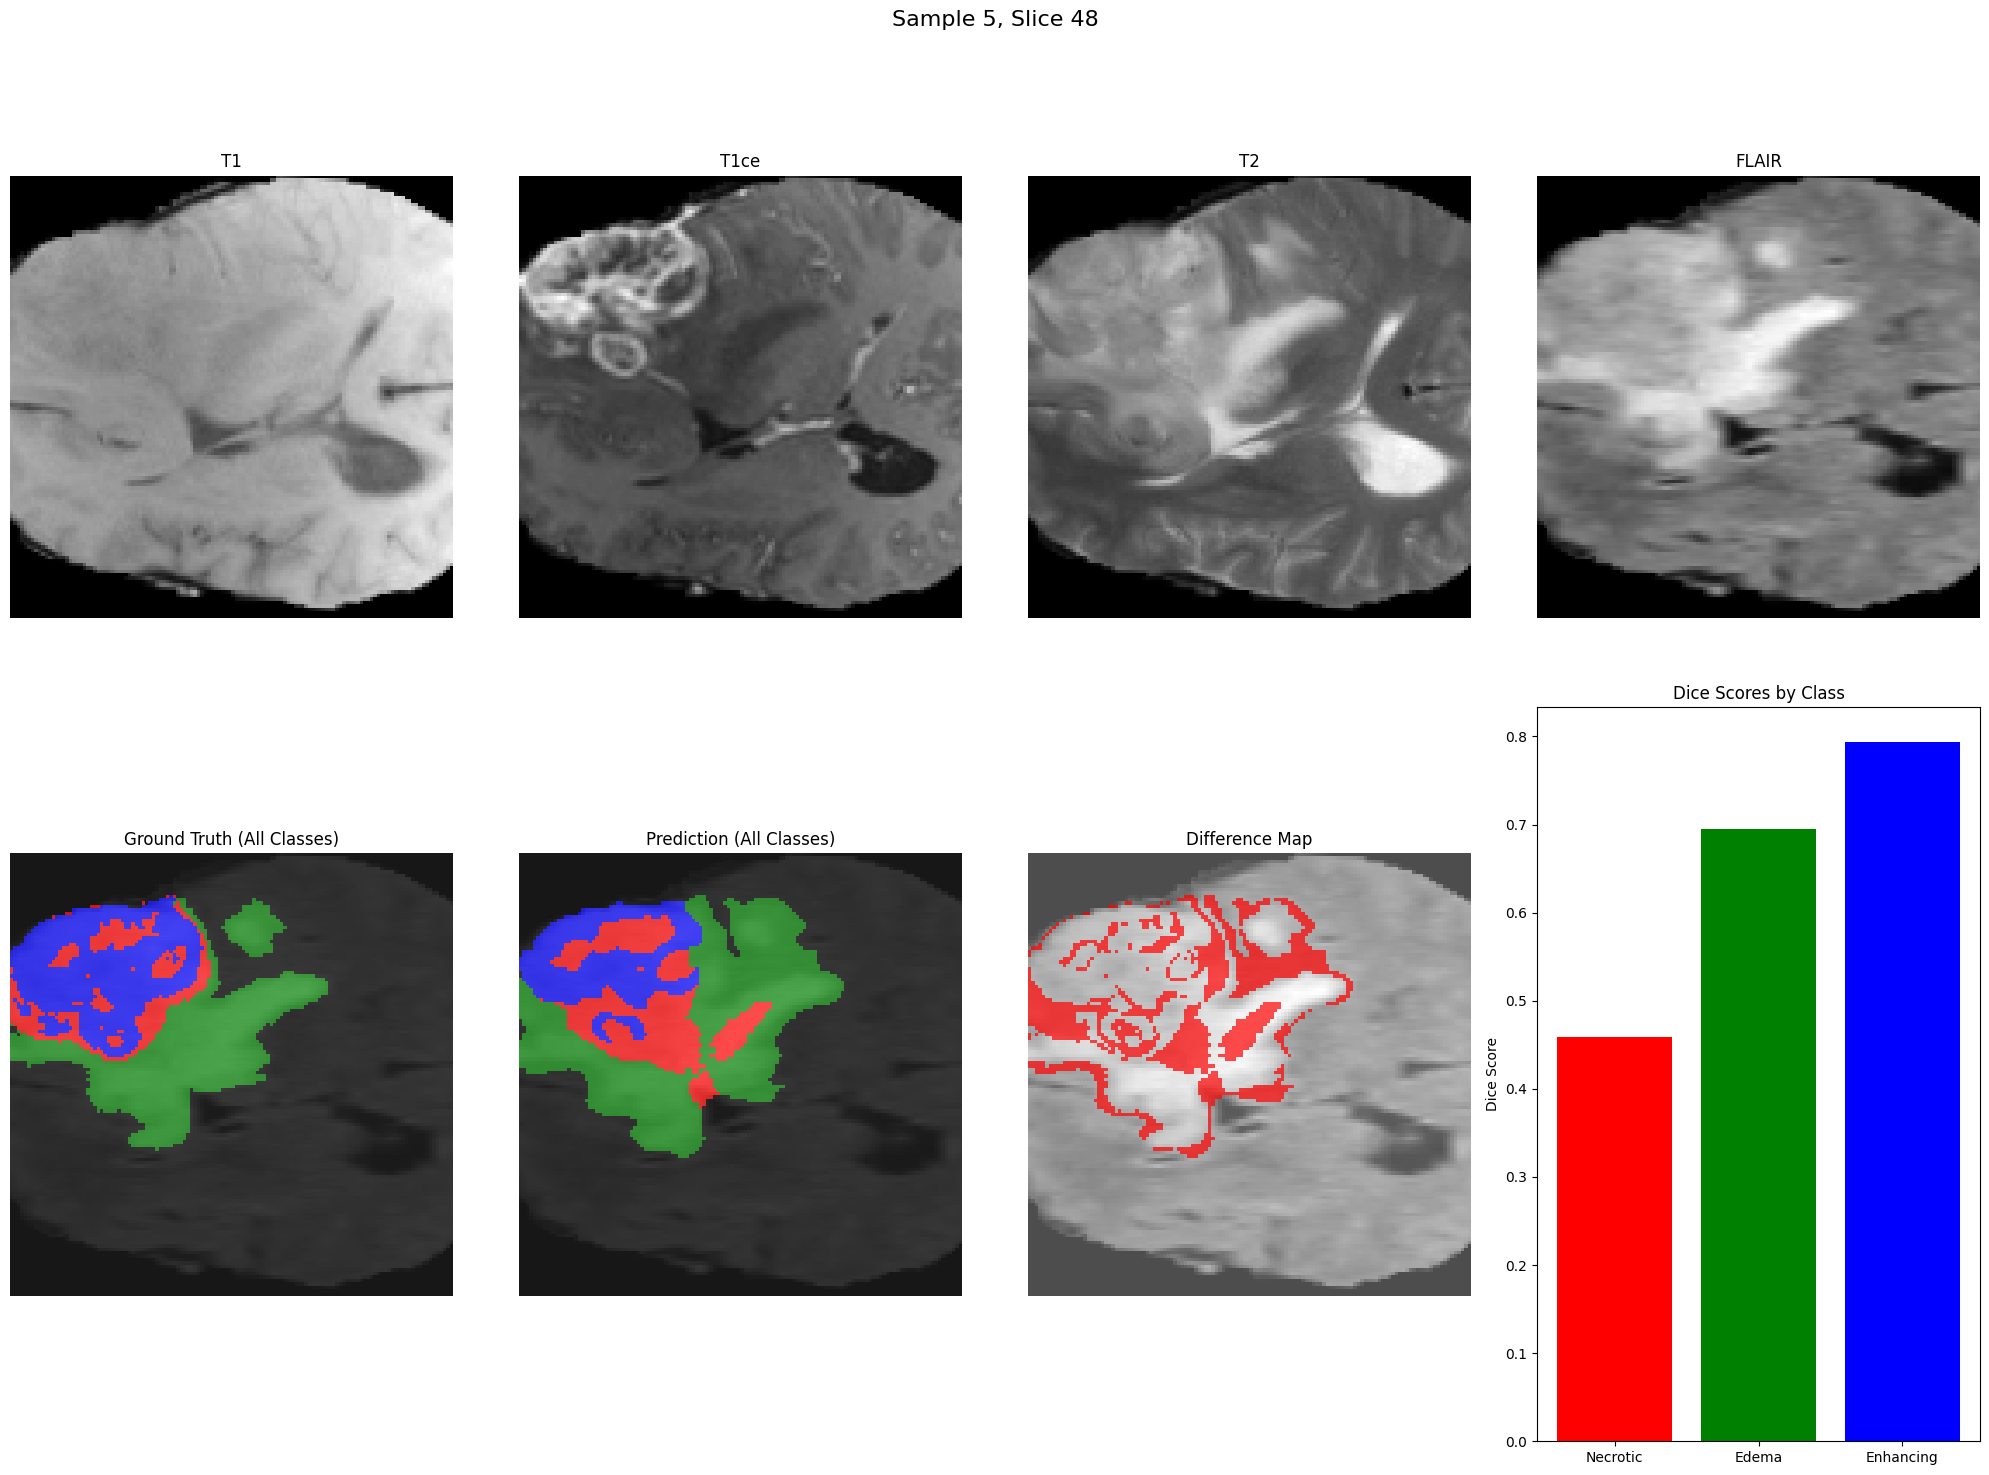

In [38]:
def visualize_segmentation_results(model, val_generator, num_samples=3, slice_idx=48):
    """
    Visualize segmentation results for validation cases showing all channels.
    
    Args:
        model: Trained segmentation model
        val_generator: Validation data generator
        num_samples: Number of samples to visualize
        slice_idx: Slice index to visualize
    """
    class_names = ['Background', 'Necrotic Tumor Core', 'Peritumoral Edema', 'Enhancing Tumor']
    
    colors = ['black', 'red', 'green', 'blue']
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    
    for sample_idx in range(min(num_samples, len(val_generator))):
        X_batch, y_batch = val_generator[sample_idx+10]
        
        y_pred = model.predict(X_batch)
        
        y_pred_classes = np.argmax(y_pred, axis=-1)
        
        # For each sample in the batch
        for i in range(len(X_batch)):
            # Get input modalities for visualization
            t1 = X_batch[i, :, :, slice_idx, 0]  # T1 modality
            t1ce = X_batch[i, :, :, slice_idx, 1]  # T1ce modality
            t2 = X_batch[i, :, :, slice_idx, 2]  # T2 modality
            flair = X_batch[i, :, :, slice_idx, 3]  # FLAIR modality
            
            # Get ground truth for each class
            y_true_channels = []
            for c in range(4):  # 4 classes
                y_true_channels.append(y_batch[i, :, :, slice_idx, c])
            
            # Convert ground truth from one-hot to class indices for overall visualization
            y_true_classes = np.argmax(y_batch[i, :, :, slice_idx], axis=-1)
            
            # Create figure for this sample
            fig = plt.figure(figsize=(20, 15))
            
            # Plot input modalities
            ax1 = fig.add_subplot(2, 4, 1)
            ax1.imshow(t1, cmap='gray')
            ax1.set_title('T1')
            ax1.axis('off')
            
            ax2 = fig.add_subplot(2, 4, 2)
            ax2.imshow(t1ce, cmap='gray')
            ax2.set_title('T1ce')
            ax2.axis('off')
            
            ax3 = fig.add_subplot(2, 4, 3)
            ax3.imshow(t2, cmap='gray')
            ax3.set_title('T2')
            ax3.axis('off')
            
            ax4 = fig.add_subplot(2, 4, 4)
            ax4.imshow(flair, cmap='gray')
            ax4.set_title('FLAIR')
            ax4.axis('off')

            
            # Plot complete ground truth and prediction
            ax9 = fig.add_subplot(2, 4, 5)
            ax9.imshow(flair, cmap='gray', alpha=0.7)
            ax9.imshow(y_true_classes, cmap=cmap, alpha=0.7)
            ax9.set_title('Ground Truth (All Classes)')
            ax9.axis('off')
            
            ax10 = fig.add_subplot(2, 4, 6)
            ax10.imshow(flair, cmap='gray', alpha=0.7)
            ax10.imshow(y_pred_classes[i, :, :, slice_idx], cmap=cmap, alpha=0.7)
            ax10.set_title('Prediction (All Classes)')
            ax10.axis('off')
            
            # Plot difference map
            ax11 = fig.add_subplot(2, 4, 7)
            diff = (y_true_classes != y_pred_classes[i, :, :, slice_idx])
            color_mask = np.zeros((*diff.shape, 4))
            color_mask[diff] = (1, 0, 0, 0.7)  # Red for differences
            ax11.imshow(flair, cmap='gray', alpha=0.7)
            ax11.imshow(color_mask)
            ax11.set_title('Difference Map')
            ax11.axis('off')
            
            # Plot Dice score for each class
            dice_scores = []
            for c in range(1, 4):  # Skip background class (0)
                true_mask = y_true_classes == c
                pred_mask = y_pred_classes[i, :, :, slice_idx] == c
                
                # Calculate Dice
                intersection = np.sum(true_mask & pred_mask)
                union = np.sum(true_mask) + np.sum(pred_mask)
                dice = 2.0 * intersection / (union + 1e-8) if union > 0 else 1.0
                dice_scores.append(dice)
            
            ax12 = fig.add_subplot(2, 4, 8)
            ax12.bar(range(3), dice_scores, color=['red', 'green', 'blue'])
            ax12.set_xticks(range(3))
            ax12.set_xticklabels(['Necrotic', 'Edema', 'Enhancing'])
            ax12.set_ylabel('Dice Score')
            ax12.set_title('Dice Scores by Class')
            
            plt.suptitle(f'Sample {sample_idx+1}, Slice {slice_idx}', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'segmentation_vis_sample_{sample_idx+1}_slice_{slice_idx}.png', dpi=150, bbox_inches='tight')
            plt.show()
            


print("Generating visualizations...")
visualize_segmentation_results(model, val_generator, num_samples=5)

# Deployment and 3D Visualization:

In [15]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 37.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 111.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00


In [19]:
import gradio as gr
import numpy as np
import plotly.graph_objects as go
import tensorflow as tf

modality_map = {
    'FLAIR': 0,
    'T1ce': 1,
    'T1': 2,
    'T2': 3
}


def preprocess_mri(volume):
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume) + 1e-6)
    volume[volume < 0.05] = np.nan  
    return volume

def visualize_prediction(file_index_str, modality):
    file_index = int(file_index_str)

    x, y_true = val_generator[file_index]
    x = x[0]  # (H, W, D, C)
    y_true = y_true[0]  # (H, W, D, 4)
    y_true_label = np.argmax(y_true, axis=-1)

    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred_label = np.argmax(y_pred, axis=-1)

    H, W, D, C = x.shape
    fig = go.Figure()

    # Brain MRI volume (selected modality)
    mod_index = modality_map[modality]
    brain = preprocess_mri(x[..., mod_index])
    X, Y, Z = np.mgrid[:H, :W, :D]

    fig.add_trace(go.Volume(
        x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
        value=brain.flatten(),
        opacity=0.2,
        surface_count=4,
        colorscale='Gray',
        name=f'{modality} MRI',
        showscale=False
    ))

 
    tumor_labels = {
        1: ('NCR/NET', 'blue', 'lightblue'),
        2: ('Edema', 'green', 'lightgreen'),
        3: ('Enhancing Tumor', 'red', 'pink')
    }

    for label_val, (label_name, pred_color, gt_color) in tumor_labels.items():
        mask_pred = (y_pred_label == label_val)
        if np.any(mask_pred):
            x_mask, y_mask, z_mask = np.where(mask_pred)
            fig.add_trace(go.Scatter3d(
                x=x_mask, y=y_mask, z=z_mask,
                mode='markers',
                marker=dict(size=2, color=pred_color, opacity=0.4),
                name=f'Pred: {label_name}',
                visible=True
            ))

        mask_gt = (y_true_label == label_val)
        if np.any(mask_gt):
            x_gt, y_gt, z_gt = np.where(mask_gt)
            fig.add_trace(go.Scatter3d(
                x=x_gt, y=y_gt, z=z_gt,
                mode='markers',
                marker=dict(size=2, color=gt_color, opacity=0.3),
                name=f'True: {label_name}',
                visible=True
            ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
            bgcolor='rgba(0,0,0,0)'
        ),
        legend=dict(itemsizing='constant', title='Legend', itemclick='toggle'),
        margin=dict(l=0, r=0, b=0, t=40),
        title='🧠 3D Brain Segmentation: Prediction vs Ground Truth',
        height=700
    )

    return fig



# Gradio UI components
val_choices = [str(i) for i in range(len(val_generator))]
modality_choices = list(modality_map.keys())

dropdown_index = gr.Dropdown(choices=val_choices, label="Select Validation Sample Index", value="0")
dropdown_mod = gr.Dropdown(choices=modality_choices, label="Select MRI Modality", value="FLAIR")

# Interface
demo = gr.Interface(
    fn=visualize_prediction,
    inputs=[dropdown_index, dropdown_mod],
    outputs=gr.Plot(label="3D Segmentation Viewer"),
    title="🧠 Brain Tumor Segmentation - Interactive 3D Viewer",
    description="Select a validation sample and MRI modality to view predicted segmentation masks in 3D."
)

demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://bbe3079aa5f0cfdfa6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
